# Анализ убытков приложения ProcrastinatePRO+

## Описание и цели проекта

Компания развлекательного приложения **Procrastinate Pro+** последние несколько месяцев терпит убытки, несмотря на огромные вложения в рекламу. *Моя задача, как маркетингового аналитика*, разобраться в причинах и *помочь компании выйти в плюс*.

В моем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях;
- выгрузка их покупок за этот период;
- рекламные расходы.


Мне необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.

## Открытие файлов с данными

### Загрузка и открытие таблиц

In [1]:
# Загружаем библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загружаем данные 

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv', sep=','), # визиты
    pd.read_csv('/datasets/orders_info_short.csv', sep=','), # заказы
    pd.read_csv('/datasets/costs_info_short.csv', sep=',')   # расходы
)

# Устанавливаем максимальное количество выводимых на экран столбцов
pd.options.display.max_columns=40

### Вывод первых строк таблиц

In [3]:
display(visits.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Описание данных

Структура **visits_info_short.csv** (лог сервера с информацией о посещениях сайта):
* *User Id* — уникальный идентификатор пользователя;
* *Region* — страна пользователя;
* *Device* — тип устройства пользователя;
* *Channel* — идентификатор источника перехода;
* *Session Start* — дата и время начала сессии;
* *Session End* — дата и время окончания сессии.

Структура **orders_info_short.csv** (информация о заказах):
* *User Id* — уникальный идентификатор пользователя;
* *Event Dt* — дата и время покупки;
* *Revenue* — сумма заказа.

Структура **costs_info_short.csv** (информация о расходах на рекламу):
* *dt* — дата проведения рекламной кампании;
* *Channel* — идентификатор рекламного источника;
* *costs* — расходы на эту кампанию.

### Общая информация о данных

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


## Предообработка данных

На предыдущем этапе мы увидели, что пропущенных значений в данных нет.  
В типах данных все хорошо, необходимо только преобразовать данные о времени.  
Также стоит проверить наличие в категориальных данных явных и неявных дубликатов.

### Переименование колонок

Для начала приведем названия колонок в удобный для работы формат (сделаем все буквы строчными и уберем пробелы между словами). 

In [7]:
#подготовим небольшую функцию, чтобы ускорить и упростить работу

def good_cols(df): 
    df.columns = \
    [x.lower().replace(' ', '_') for x in df.columns]  # приводим к строчному формату и заменяем пробелы 
    print(list(df))                                    # на подчеркивание, проверяем результат

In [8]:
good_cols(visits)
good_cols(orders)
good_cols(costs)

['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
['user_id', 'event_dt', 'revenue']
['dt', 'channel', 'costs']


### Изменение типов данных

Преобразуем данные о времени.

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start']) 
visits['session_end'] =  pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Изучение дубликатов в данных

Сначала проверим наличие неявных дубликатов в категориальных данных.

In [10]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [11]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [12]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [13]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявных дубликатов в категориальных данных не обнаружено. Проверим явные.

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

## Подготовка функций

Теперь подготовим необходимые функции для расчёта и анализа LTV, ROI, удержания (Retention Rate) и конверсии.

### Функция для создания профилей пользователей

In [17]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для подсчёта Retention Rate

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для подсчёта конверсии

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для подсчёта LTV и ROI

In [20]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания данных

In [21]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для построения графика Retention Rate

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для построения графика конверсии

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных


### Профили

Составим профили пользователей, а затем определим минимальную и максимальную даты привлечения пользователей.

In [25]:
users = get_profiles(visits, orders, costs)
users.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
print('Минимальная дата привлечения {}'.format(users['first_ts'].dt.date.min())) 
print('Максимальная дата привлечения {}'.format(users['first_ts'].dt.date.max())) 

Минимальная дата привлечения 2019-05-01
Максимальная дата привлечения 2019-10-27


Как мы видим, даты совпадают с периодом, указанным в задании.

Далее рассмотрим распределения количества пользователей по странам, девайсам и источникам привлечения, узнаем доли платящих пользователей по этим параметрам.  
Подготовим для этого функцию.

In [27]:
def ratio(param):
    df = users.pivot_table(
        index=param, 
        values = ['user_id', 'payer'], 
        aggfunc = {'user_id': 'count', 'payer':'mean'}
)
    df=df[['user_id', 'payer']]
    df.columns = ['users', 'payer_ratio']
    display(df
            .sort_values(by='users', ascending=False)
            .style.format({'payer_ratio': '{:.1%}'})
            .background_gradient(cmap='Greens'))

### Пользователи по странам

Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [28]:
ratio('region')

,users,payer_ratio
region,,
United States,100002,6.9%
UK,17575,4.0%
France,17450,3.8%
Germany,14981,4.1%


Пользователи США являются основной аудиторией, на них же приходится наибольший процент платящих пользователей.

### Пользователи по типу устройства

Теперь узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [29]:
ratio('device')

,users,payer_ratio
device,,
iPhone,54479,6.2%
Android,35032,5.9%
PC,30455,5.0%
Mac,30042,6.4%


Большинство пользователей используют айфон.  
Наименьше количество среди пользователей макбуков, однако у них наивысший процент платящих пользователей, хоть и почти равный проценту платящих пользователей айфона.

### Пользователи по источнику привлечения

Рассмотрим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [30]:
ratio('channel')

,users,payer_ratio
channel,,
organic,56439,2.1%
FaceBoom,29144,12.2%
TipTop,19561,9.6%
OppleCreativeMedia,8605,2.7%
LeapBob,8553,3.1%
WahooNetBanner,8553,5.3%
RocketSuperAds,4448,7.9%
MediaTornado,4364,3.6%
YRabbit,4312,3.8%


Органические пользователи занимают первое место по количеству юзеров, но имеют наименьший процент платящих пользователей.  
Это связано с тем, что зачастую закупочные каналы оптимизируются с целью приведения максимально платящей аудитории, а органические пользователи случаются разные.  

Второе место по количеству заняли пользователи, привлеченные с помощью FaceBoom.  
Наибольшее количество платящих пользователей также оказалось именно у этого источника.

### Вывод по разделу

Большинство пользователей привлечено из США.  

Самым популярным устройством среди привлеченных пользователей является айфон.  

Источником привлечения, благодаря которому пришло наибольшее число пользователей, является FaceBoom.  

Доля платящих пользователей является наивысшей среди пользователей США, макбуков (но всего на 0.2% больше, чем у айфонов) и из источника привлечения FaceBoom.

## Маркетинг

### Общая сумма расходов

Найдем общую сумму расходов на маркетинг.

In [31]:
total_cost = users['acquisition_cost'].sum().round(2)
print(f'Общая сумма расходов составляет {total_cost} $') 

Общая сумма расходов составляет 105497.3 $


### Распределение расходов по каналам

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [32]:
channels_cost = (users
                 .pivot_table(
                     index = 'channel', 
                     values = 'acquisition_cost',
                     aggfunc = 'sum')
                )
channels_cost.columns = ['ad_cost']
channels_cost['ratio'] = channels_cost['ad_cost'] / total_cost

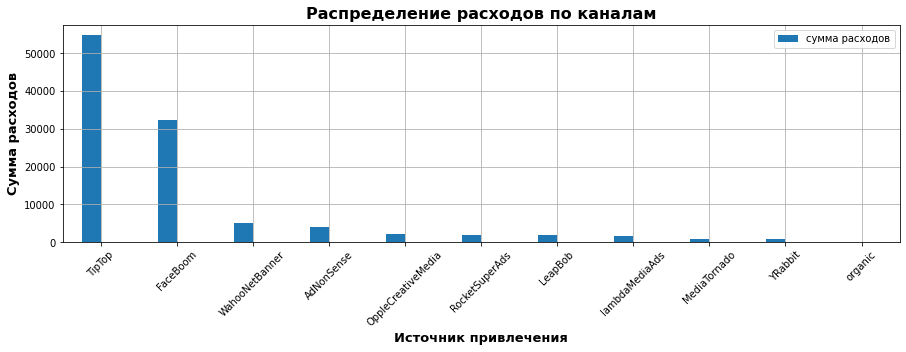

,ad_cost,ratio
channel,,
TipTop,54751.3,51.9%
FaceBoom,32445.6,30.8%
WahooNetBanner,5151.0,4.9%
AdNonSense,3911.3,3.7%
OppleCreativeMedia,2151.2,2.0%
RocketSuperAds,1833.0,1.7%
LeapBob,1797.6,1.7%
lambdaMediaAds,1557.6,1.5%
MediaTornado,954.5,0.9%


In [33]:
(channels_cost
            .sort_values(
                by='ad_cost',
                ascending=False)
            .plot(
                kind='bar', 
                figsize=(15, 4), 
                grid=True,
                rot=45)
)
plt.title('Распределение расходов по каналам', fontsize=16, fontweight="bold")
plt.legend(["сумма расходов"])
plt.xlabel("Источник привлечения", fontsize=13, fontweight="bold")
plt.ylabel("Сумма расходов", fontsize=13, fontweight="bold")
plt.show()

(channels_cost.sort_values(
                by='ad_cost',
                ascending=False)
              .style.format('{:.1f}')
              .format({'ratio':'{:.1%}'})
              .background_gradient(cmap='Blues')
)

Большинство расходов (почти 83% от общей суммы) ушло на рекламу через TipTop и FaceBoom.  
С этих же каналов, как мы выяснили ранее, и пришло наибольшее количество пользователей.

### Динамика расходов

Построим графики с визуализацией динамики изменения расходов во времени по неделям и по месяцам по каждому источнику.

In [34]:
# добавляем отдельно данные о номерах недели и месяца привлечения

users['week'] = users['first_ts'].dt.isocalendar().week
users['month'] = users['first_ts'].dt.month
#users.head()

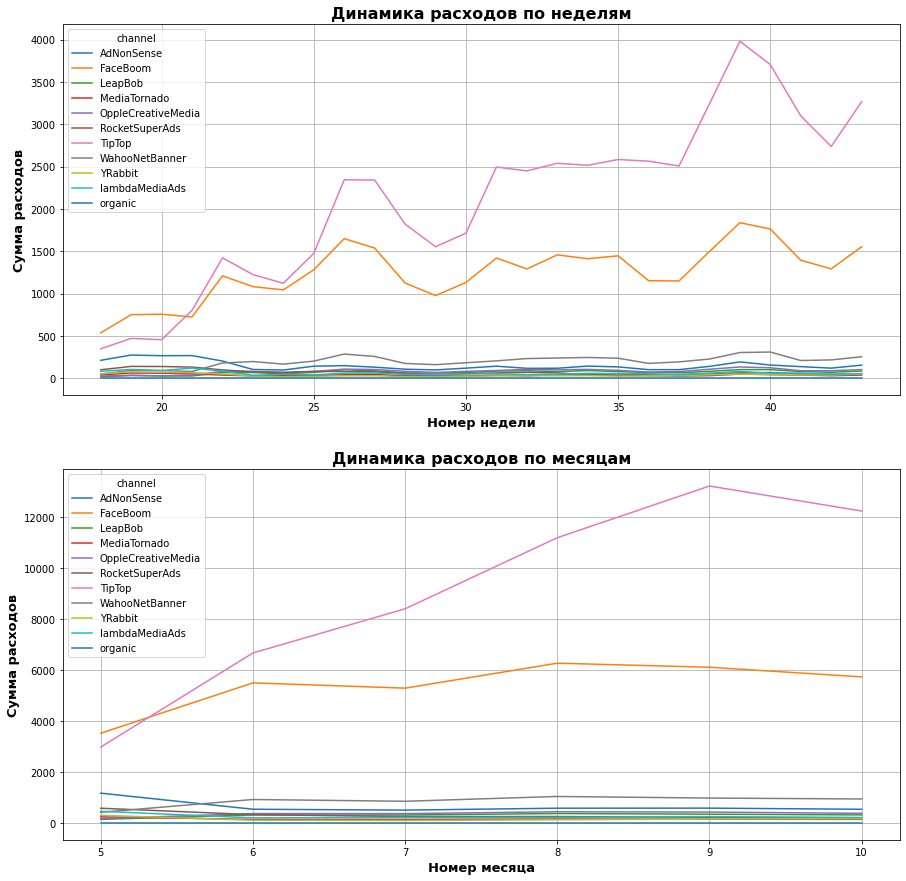

In [35]:
plt.figure(figsize=(15, 15))

# строим график динамики по неделям
ax1=plt.subplot(2, 1, 1)
(users
     .pivot_table(
         index='week', 
         columns='channel', 
         values='acquisition_cost', 
         aggfunc='sum')
     .plot(
         grid=True,
         ax=ax1)
)
plt.title('Динамика расходов по неделям', fontsize=16, fontweight="bold")
plt.xlabel("Номер недели", fontsize=13, fontweight="bold")
plt.ylabel("Сумма расходов", fontsize=13, fontweight="bold")

# график динамики по месяцам
ax2=plt.subplot(2, 1, 2)
(users
     .pivot_table(
         index='month', 
         columns='channel', 
         values='acquisition_cost', 
         aggfunc='sum')
     .plot(
         grid=True, 
         ax=ax2)
)
plt.title('Динамика расходов по месяцам', fontsize=16, fontweight="bold")
plt.xlabel("Номер месяца", fontsize=13, fontweight="bold")
plt.ylabel("Сумма расходов", fontsize=13, fontweight="bold")
plt.show()

На графиках наглядно показано, что самые большие расходы на рекламу изначально были выделены на TipTop и FaceBoom, которые с течением времени постепенно еще больше увеличивались.  
Остальные источники привлечения наоборот отличаются стабильно низкими показателями расходов в течение рассматриваемого периода времени.

### Средний CAC по каналам 

Теперь узнаем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [36]:
cac_mean = (users.groupby('channel')
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
            .sort_values('cac', ascending=False)
            .style
            .format('{:.2f}')
            .background_gradient(cmap='Reds')
)

cac_mean

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Пользователи, привлеченные через TipTop, в среднем оказались самыми дорогими.  
Вторыми идут пользователи привлеченные из FaceBoom, причем их средняя стимость меньше TipTop в два с половиной раза.

### Вывод по разделу

Мы определили, что общая сумма расходов на рекламу составляет 105497.3 $    

Большинство расходов (почти 83% от общей суммы) ушло на рекламу через TipTop и FaceBoom.
С этих же каналов, как мы выяснили ранее, и пришло наибольшее количество пользователей.  

Выяснили, что самые большие расходы на рекламу изначально были выделены на TipTop и FaceBoom, которые с течением времени постепенно еще больше увеличивались.
Остальные источники привлечения наоборот отличаются стабильно низкими показателями расходов в течение рассматриваемого периода времени.  

Пользователи, привлеченные через TipTop, в среднем оказались самыми дорогими.  
Вторыми идут пользователи, привлеченные из FaceBoom, причем их средняя стоимость меньше TipTop в два с половиной раза.
Также стоит упомянуть, что ранее мы выяснили, что пользователей, привлеченных благодаря FaceBoom, на 10 тысяч больше, чем TipTop.

## Оценка окупаемости рекламы

Проанализируем окупаемость рекламы.  
По условию задания на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.  
Далее при анализе органический трафик будет исключен, т.к. за этих пользователей компания не платит, а доход от них может исказить данные.

In [37]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа 
users_no = users.query('channel != "organic"') # исключаем органиков

### Общая окупаемость

Сначала рассмотрим общую окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

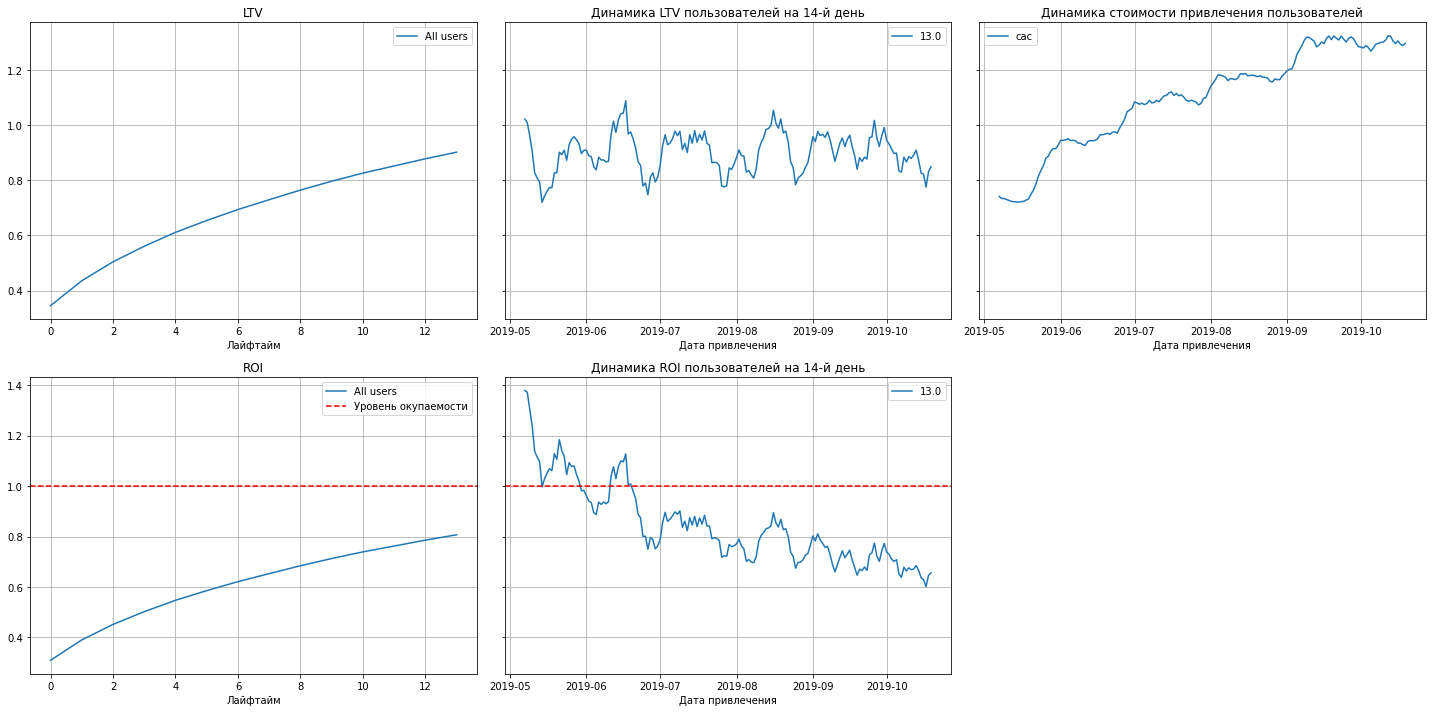

In [38]:
# сначала высчитываем показатели LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(users_no, orders, observation_date, horizon_days) 

# затем строим графики 
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Аномалии в LTV отсутствуют, присутствует сезонность, но динамика показателя в целом стабильна.  
В показателе CAC виден резкий скачок в июне, после чего он начинает постепенно увеличиваться.  
Реклама не окупается, бизнес-план не выполняется (ROI к 14 дню жизни едва пересекает отметку в 80%).  
В динамике ROI пользователей на 14-й день жизни видим, что примерно с середины июня показатель перестал пересекать уровень окупаемости, скорее всего это связано с увеличением CAC в июне. 

### Общая конверсия и удержание

Проверим конверсию пользователей и динамику её изменения, затем то же самое сделаем с удержанием пользователей.

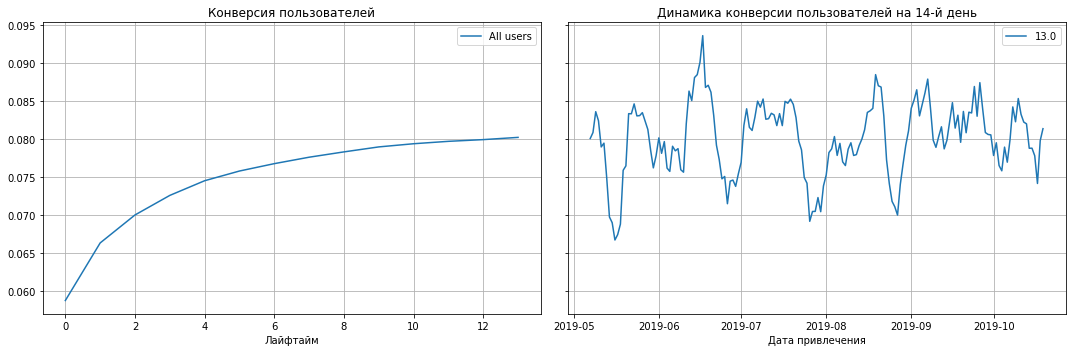

In [39]:
# вычислияем конверсию 
conversion_raw, conversion, conversion_history = get_conversion(users_no, orders, observation_date, horizon_days)
# строим ее графики
plot_conversion(conversion, conversion_history, horizon_days)

С общей конверсией в целом все в порядке, присутствует сезонность, начиная с июля она стабильно находилась в диапазоне между 7,5% и 9%. 

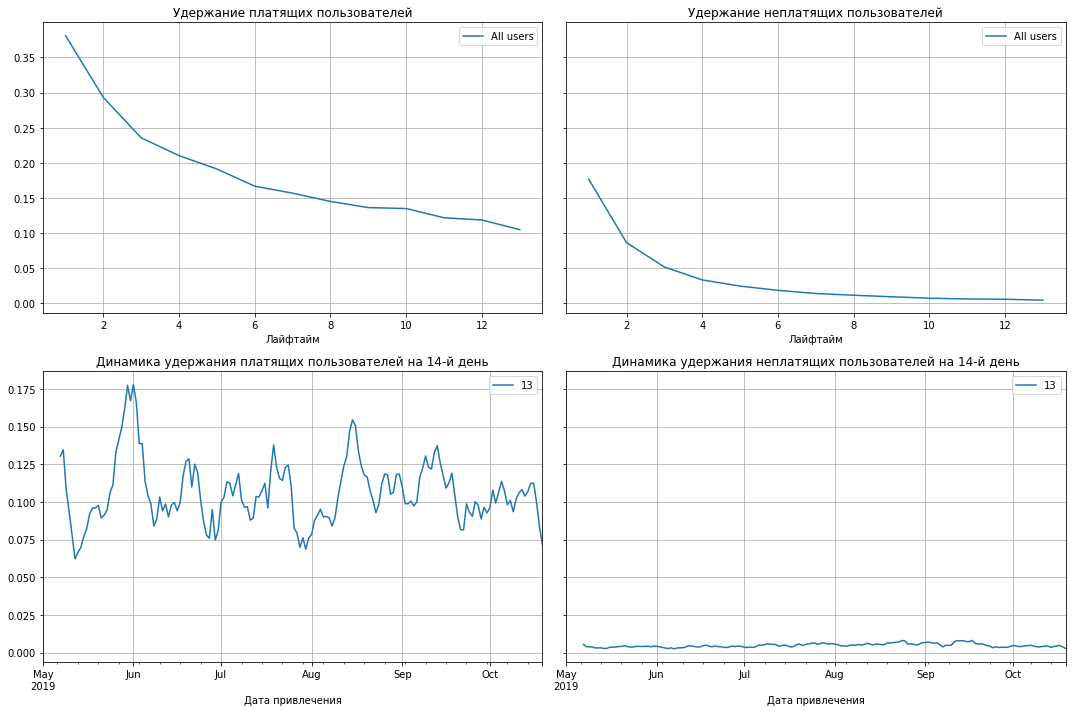

In [40]:
# находим удержание
retention_raw, retention, retention_history = get_retention(users_no, visits, observation_date, horizon_days)
# строим его графики
plot_retention(retention, retention_history, horizon_days)

С удержанием тоже ничего примечательного не наблюдается. Показатель стабилен.

Далее будем рассматривать окупаемость, удержание и конверсию по устройствам, странам и каналам отдельно.

### Устройства

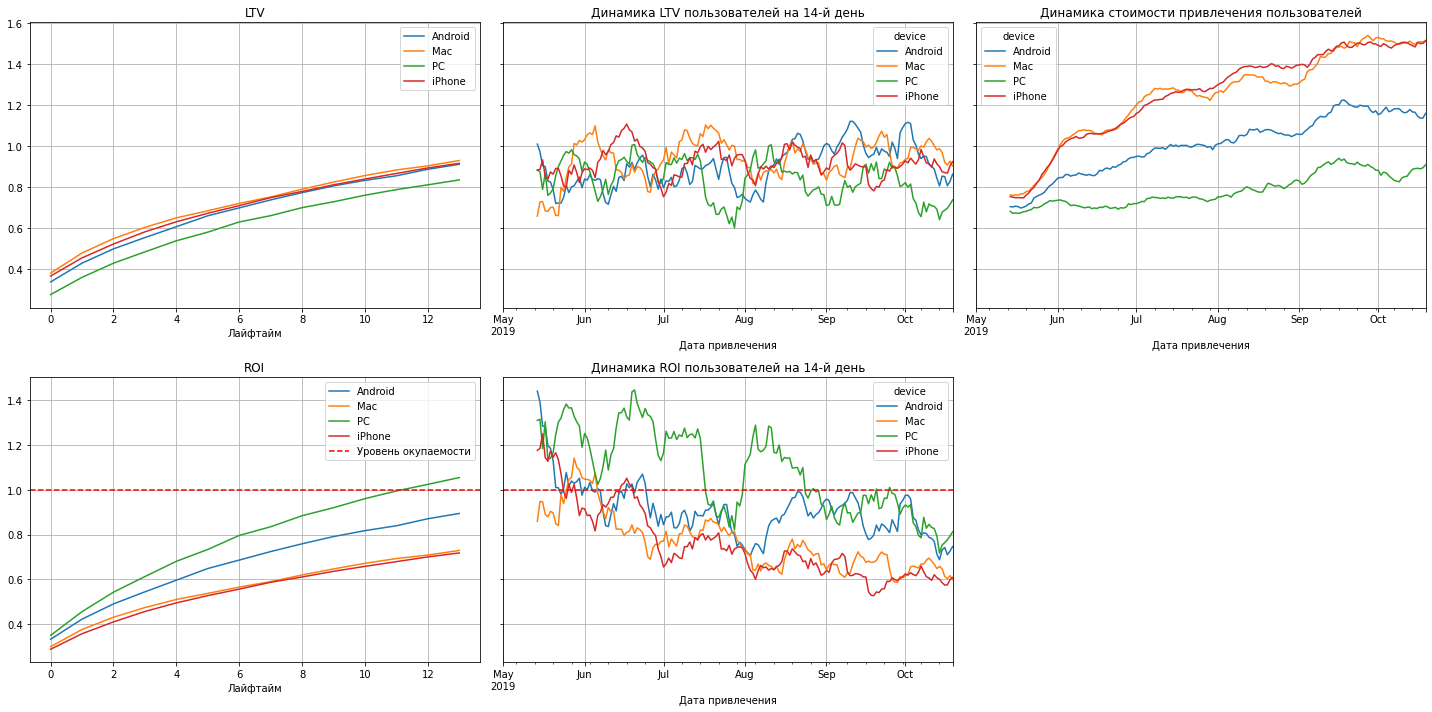

In [41]:
dimensions=['device']

#LTV, ROI, CAC
ltv_raw, ltv, ltv_history, roi, roi_history = \
get_ltv(users_no, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

LTV по устройствам стабилен.  
Стоимость привлечения постепенно растет на всех девайсах. Дороже всего обходятся пользователи устройств от Apple.  
Окупаются лишь пользователи ПК (на 12 день).  
Пользователи айфонов и макбуков на 14-й день достигают лишь отметки около 70% окупаемости.  
В динамике наблюдается общая тенденция понижения окупаемости пользователей со всех девайсов.  
Стоит заметить, что окупаемость пользователей ПК на 14 день перестала пересекать уровень только начиная с сентября, тогда как для остальных устройств это началось еще примерно с июня.

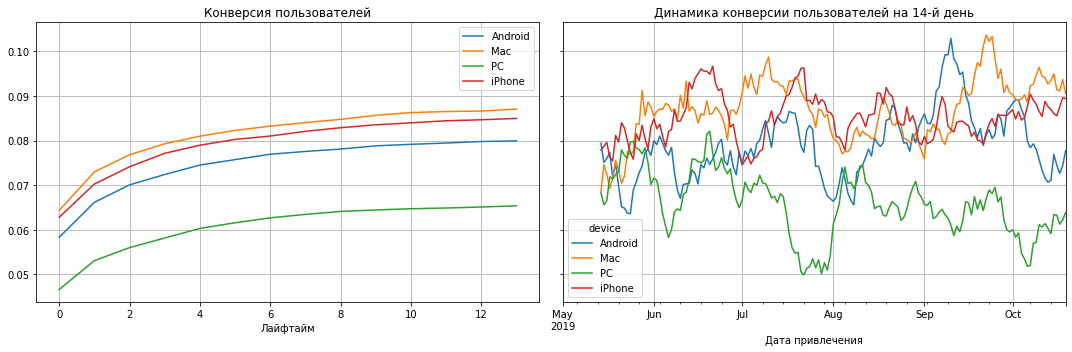

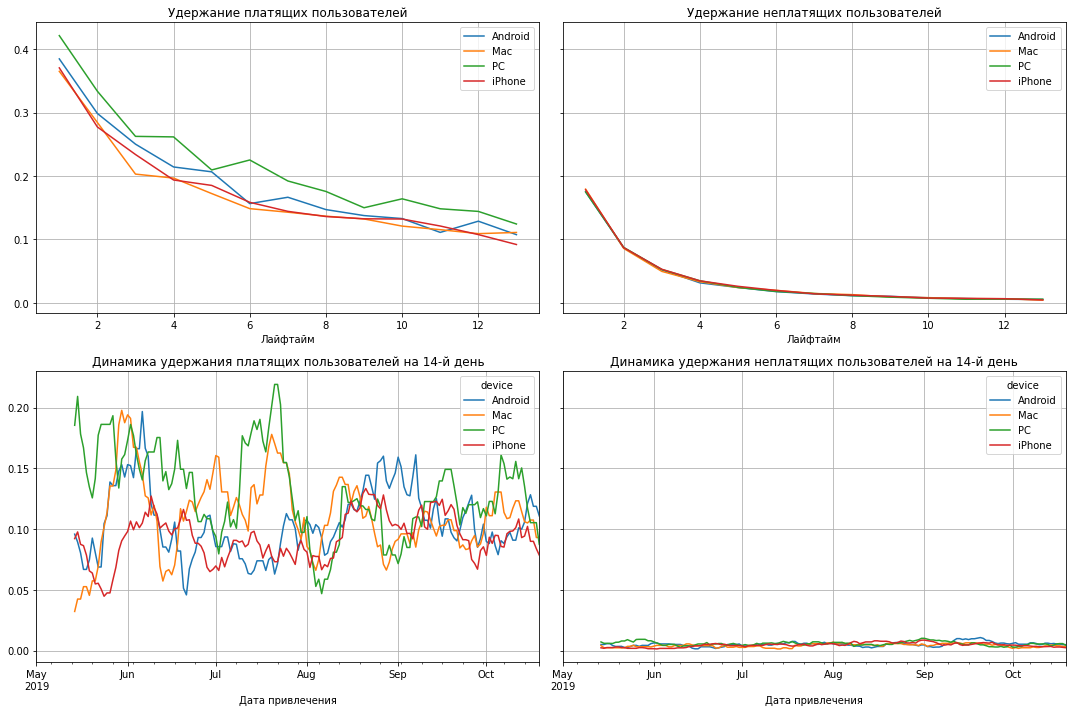

In [42]:
# Конверсия
conversion_raw, conversion, conversion_history = \
get_conversion(users_no, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

# Удержание
retention_raw, retention, retention_history = \
get_retention(users_no, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention, retention_history, horizon_days, window=14)

Показатели конверсии и удержания для всех устройств примерно одинаковы.  
Хотя пользователи ПК и конвертируются хуже остальных, нам это ни о чем не говорит, их окупаемость все еще выше остальных.  

Похоже, что дело не в устройствах. Перейдем к странам.

### Страны

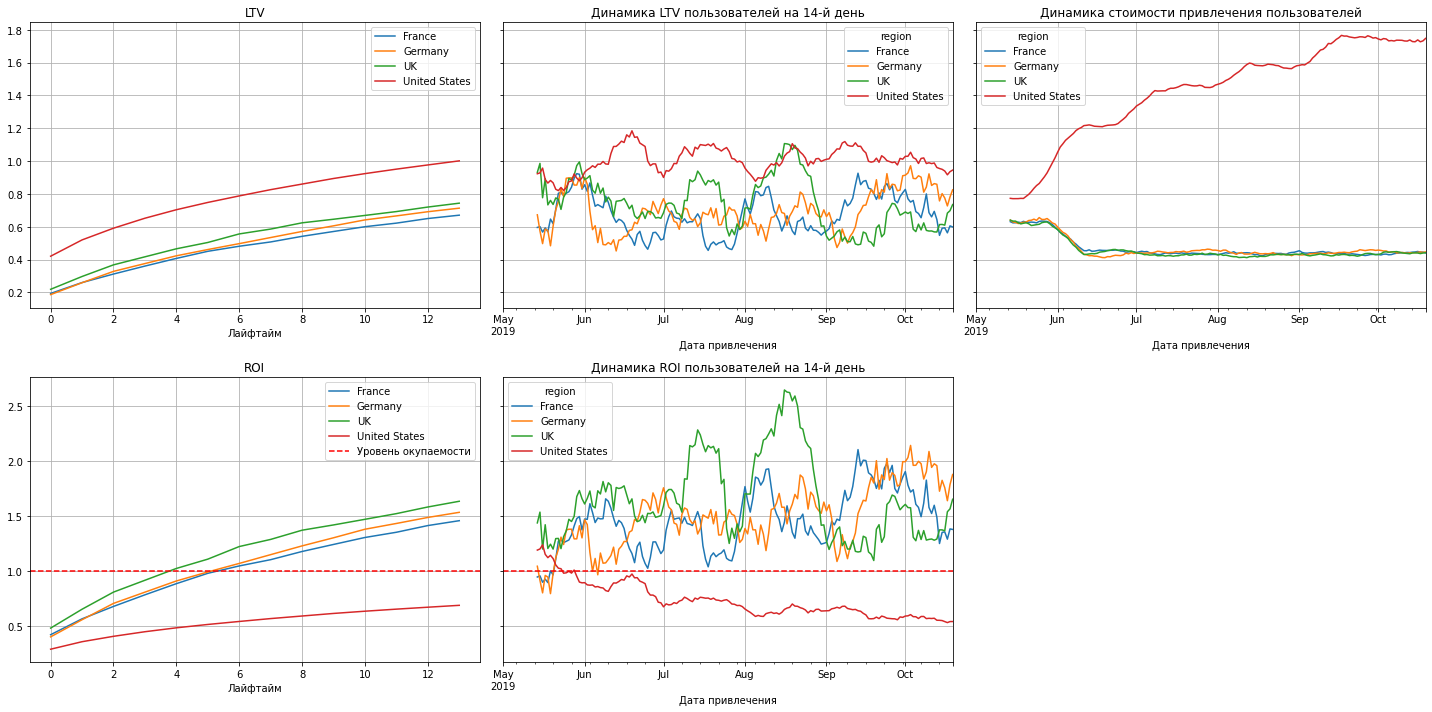

In [43]:
dimensions=['region']

#LTV, ROI, CAC
ltv_raw, ltv, ltv_history, roi, roi_history = \
get_ltv(users_no, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

LTV и ее динамика стабильны, этот показатель у США чуть лучше, чем у остальных стран.  
Однако с остальными параметрами у США всё заметно плохо.  
Из всех стран не окупается только США, причем другие страны окупаются уже на 5-6 день жизни.  
Динамика ROI показывает, что окупаемость США на 14-й день жизни самая низкая и с течением времени опускается всё ниже. Остальные же страны показывают прекрасную стабильность и на всем отрезке времени не опускаются ниже 100%-го уровня окупаемости, местами даже превышая окупаемость в 200%.  
САС всех стран кроме США стабильно низок на всем промежутке изучаемого времени и в июне даже стал ниже, тогда как САС США в июне наоборот стал повышаться. Очевидно, что САС США неоправданно завышена.  

Теперь узнаем причину: низкая конверсия или низкое удержание.

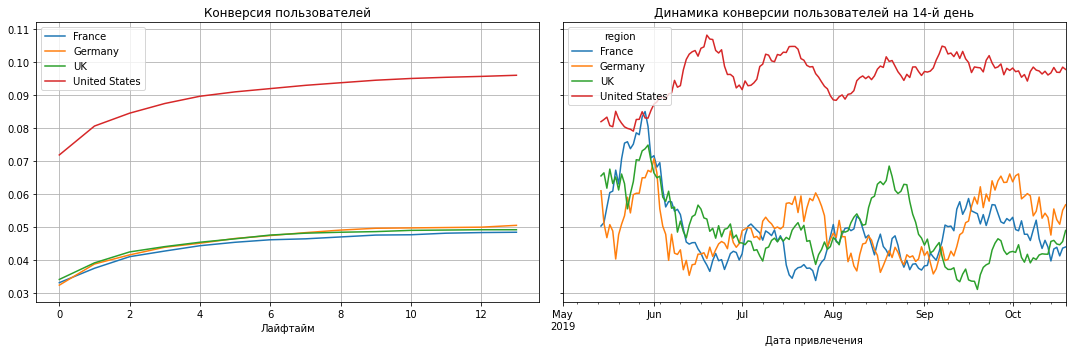

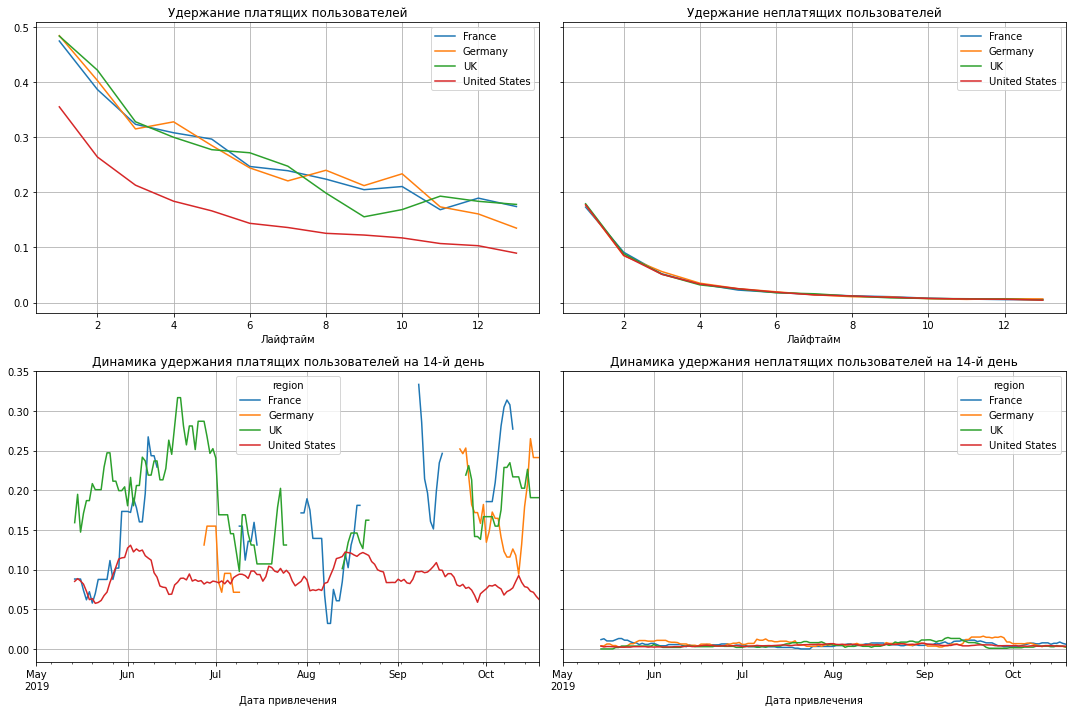

In [44]:
# Конверсия
conversion_raw, conversion, conversion_history = \
get_conversion(users_no, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

# Удержание
retention_raw, retention, retention_history = \
get_retention(users_no, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention, retention_history, horizon_days, window=14)

С конверсией у США все отлично, причем на всём временном отрезке. Конверсия США постоянно выше примерно в 2 раза, чем у других стран.  
А вот удержание платящих пользователей из США самое худшее, почти в 2 раза меньше остальных стран.   
В динамике 14-го дня удержание США стабильно самое низкое и постоянно находится в районе 10%, тогда как удержание в других стран может достигать 30%.

### Источники рекламы

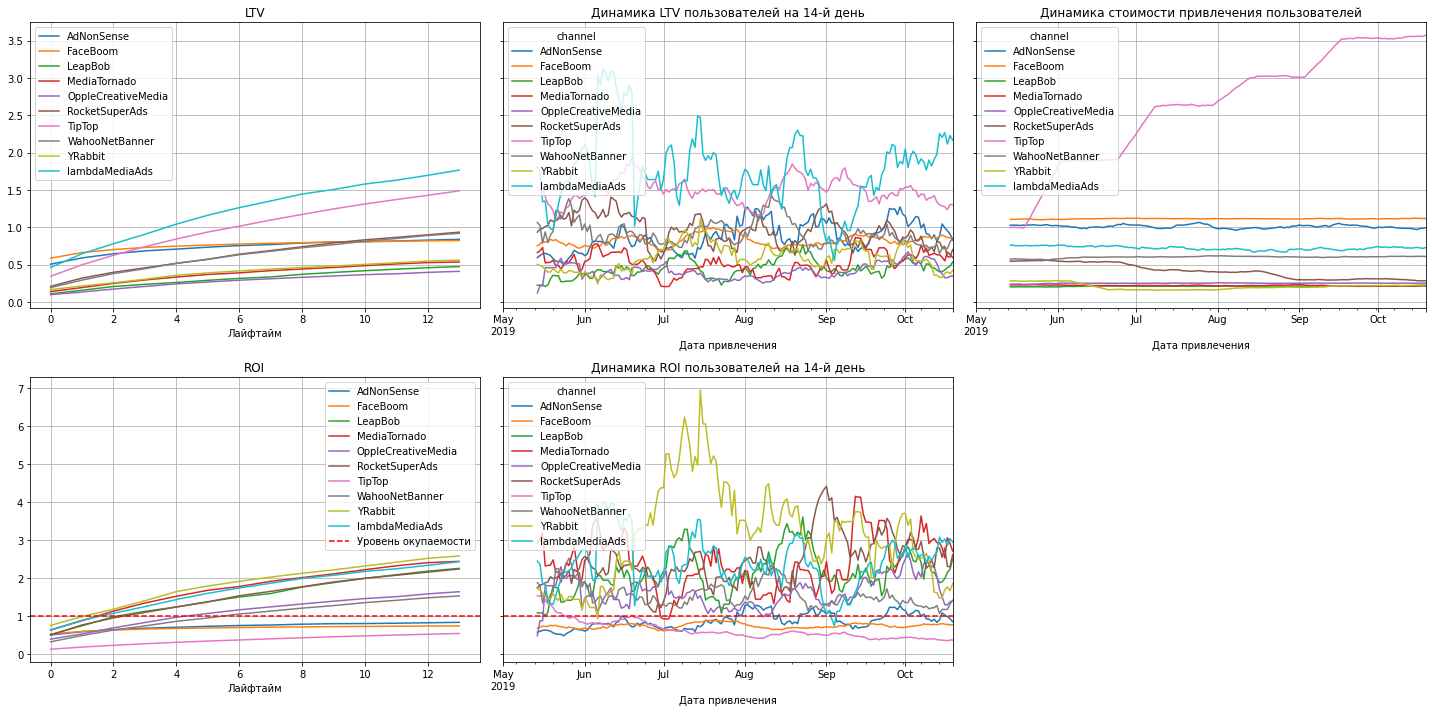

In [45]:
dimensions=['channel']

#LTV, ROI, CAC
ltv_raw, ltv, ltv_history, roi, roi_history = \
get_ltv(users_no, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

LTV всех каналов рекламы стабилен, лучшие показатели у lambdaMediaAds и TipTop.  
Динамика стоимости привлечения стабильна у всех каналов, кроме TipTop. TipTop имеет значительно наибольшую CAC и постоянно растет.  
Почти все каналы показывают постоянную окупаемость, за исключением TipTop, FaceBoom и AdNonSense.

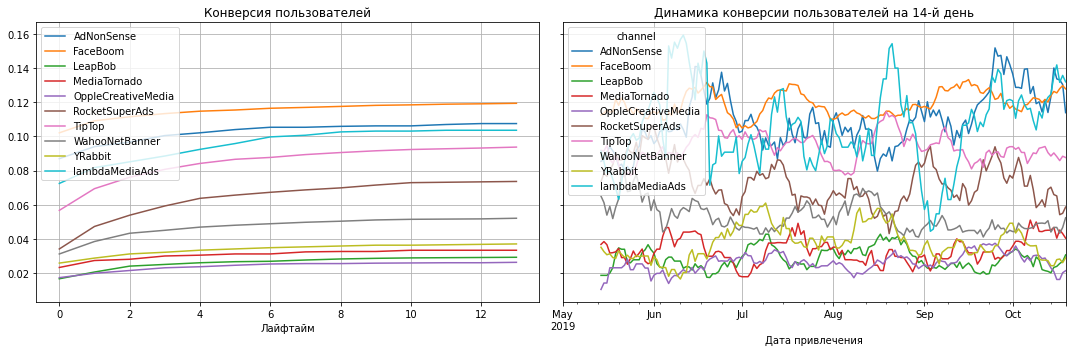

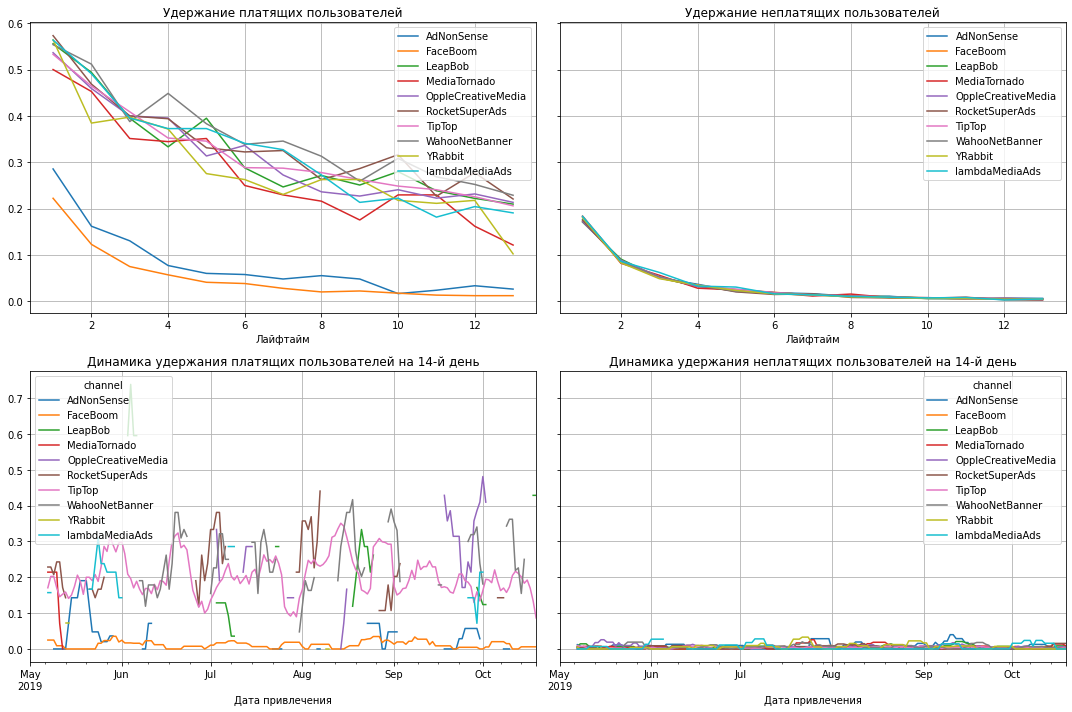

In [46]:
# Конверсия
conversion_raw, conversion, conversion_history = \
get_conversion(users_no, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

# Удержание
retention_raw, retention, retention_history = \
get_retention(users_no, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention, retention_history, horizon_days, window=7)

Здесь мы видим очень низкий показатель удержания платящих пользователей, привлеченных через FaceBoom и AdNonSense.

Плохое удержание в US - существенная проблема.  
Можно заметить, что динамика стоимости привлечения по US и TipTop очень схожи.  
Оставим только пользователей из US и посмотрим распределение пользователей по каналам привлечения. 

In [54]:
users_us = users_no.query('region == "United States"')
users_us['channel'].value_counts()

FaceBoom          29144
TipTop            19561
RocketSuperAds     4448
MediaTornado       4364
YRabbit            4312
Name: channel, dtype: int64

Ранее мы уже выяснили, что общее число пользователей, привлеченных из FaceBoom и TipTop, составляет 29144 и 19561, соответственно.  
Это совпадает с количеством пользователей из US, привлеченных по этим крупнейшим каналам.  
Таким образом, выходит, что эти два канала привлекают пользователей только из US.

### Вывод по разделу

В настоящее время реклама, направленная на привлечения пользователей, в целом не окупается.  

В большей степени негативное влияние на окупаемость рекламы оказывают пользователи, привлеченные из США, и пользователи, пришедшие благодаря рекламе через TipTop, FaceBoom и AdNonSense.  

Важно отметить связь проблемных каналов TipTop и FaceBoom с US. Эти каналы привлекают пользователей исключительно только из US. 

Проблема может заключаться с доступностью приложения в США. Техподдержке приложения стоит проверить логи из США.  
Для более точного выявления возможной причины не хватает данных о дополнительных событиях, в будущем рекомендуется предоставлять также и эту информацию.  

Рекламному отделу рекомендуется пересмотреть вложения в рекламу от TipTop.  
Реклама в TipTop является наиболее дорогой по сравнению с остальными используемыми источниками и постоянно растет, она ни разу не окупилась. От этого источника стоит отказаться.

Стоит обратить внимания и на рекламу от FaceBoom и AdNonSense. Пользователи, привлеченные из этих каналов, хорошо конвертируются, но имеют очень низкие показатели удержания, следуют получить дополнительно информацию, после чего подробнее разобраться с возможными причинами.  

Также рекомендуется чаще обращать внимание на показатели маркетинга, т.к. похоже, что маркетинговый отдел долгое время сжигал деньги не очень эффективно.

## Общий вывод

Большинство пользователей привлечено из US.  
Самым популярным устройством среди привлеченных пользователей является айфон.  
Источником привлечения, благодаря которому пришло наибольшее число пользователей, является FaceBoom.  
Доля платящих пользователей является наивысшей среди пользователей США, устройств Apple и из источника привлечения FaceBoom.

Общая сумма расходов на рекламу составляет 105 497.3 $  
Большинство расходов (почти 83% от общей суммы) ушло на рекламу через TipTop и FaceBoom.  
С этих же каналов, как мы выяснили ранее, и пришло наибольшее количество пользователей.  
Самые большие расходы на рекламу изначально были выделены на TipTop и FaceBoom, которые с течением времени постепенно еще больше увеличивались.  
Остальные источники привлечения наоборот отличаются стабильно низкими показателями расходов в течение рассматриваемого периода времени.  
Пользователи, привлеченные через TipTop, в среднем оказались самыми дорогими.  
Вторыми идут пользователи, привлеченные из FaceBoom, причем их средняя стоимость меньше TipTop в два с половиной раза.  
Также стоит упомянуть, что ранее мы выяснили, что пользователей, привлеченных благодаря FaceBoom, на 10 тысяч больше, чем TipTop.  

В большей степени негативное влияние на окупаемость рекламы оказывают пользователи, привлеченные из US, и пользователи, пришедшие благодаря рекламе через TipTop, FaceBoom и AdNonSense.  
Важно отметить связь проблемных каналов TipTop и FaceBoom с US. Эти каналы привлекают пользователей исключительно только из US.  
Проблема может заключаться с доступностью приложения в US.  
Техподдержке приложения стоит проверить логи из US.  

Для более точного выявления возможной причины не хватает данных о дополнительных событиях, в будущем рекомендуется предоставлять также и эту информацию.  

Рекламному отделу рекомендуется пересмотреть вложения в рекламу от TipTop.
Реклама в TipTop является наиболее дорогой по сравнению с остальными используемыми источниками и постоянно растет, она ни разу не окупилась. От этого источника стоит отказаться.

Стоит обратить внимания и на рекламу от FaceBoom и AdNonSense. Пользователи, привлеченные из этих каналов, хорошо конвертируются, но имеют очень низкие показатели удержания, следуют получить дополнительно информацию, после чего подробнее разобраться с возможными причинами.  

Также рекомендуется чаще обращать внимание на показатели маркетинга, т.к. похоже, что маркетинговый отдел долгое время сжигал деньги не очень эффективно.